In [29]:
# Autoreload modules without having to restart the notebook kernel.
# hi bilbo
%load_ext autoreload
%autoreload 2

import sys
import os
import networkx as nx 
import scipy as sp 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import markov_clustering as mcl
import community as community_louvain

# Introduce the project directory to your system's path to make data/lib folders visible.

# sys.path.insert(1, "..")

# Plotting code stolen from Georg's notebook.
# matplotlib inline
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 22}
plt.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
#import lib.graph
#import lib.cluster


In [132]:
#FUNCTIONS

# shortest path tree
#Given graph, node, find a tree with shortest path to all nodes
def sp_tree(G, n, k=None):
    sp = nx.Graph()
    sp.add_node(n)
    set = []
    set.append(n)
    while set:
        current = set[0]
        set = set[1:]
        nbs = G.neighbors(current)
        for nb in nbs:
            if nb in sp:
                continue
            if k!= None:
                if nx.shortest_path_length(G,nb,n) > k:
                    continue
            set.append(nb)
            sp.add_node(nb)
            sp.add_edge(current, nb)
    return sp

#dict to sorted list (of tuples)
def dict_to_sortedlist(dict):
    dict = list(dict.items())
    for i in range(len(dict)-1):
        for j in range(i+1, len(dict)):
            if dict[i][1] > dict[j][1]:
                temp = dict[i]
                dict[i] = dict[j]
                dict[j] = temp
    return(dict)
 
#get Laplacian
def get_L(G):
    A = nx.linalg.adjacency_matrix(G)
    Aarray = np.asarray(A.todense())
    D = np.zeros(A.shape)
    Dinv = np.zeros(A.shape)
    for i in range(D.shape[0]):
        D[i][i] = sum(Aarray[i])
        Dinv[i][i] = 1/D[i][i]
    D = sp.sparse.csr_matrix(D)
    Dinv = sp.sparse.csr_matrix(Dinv)
    L_g = D-A
    return L_g

#K-means
def cluster(L, k, G):
    eigs, v = np.linalg.eigh(L.todense())
    V = np.zeros((k, v.shape[0]))
    v = np.matrix.transpose(v)
    for i in range(k):
       V[i]= v[i] 
    V = np.matrix.transpose(V)
    km = KMeans(k).fit(V)
    labels = km.labels_
    x = dict()
    for i in range(len(G.nodes)):
        x[list(G.nodes)[i]] = labels[i]
    return x 

#PATHWAY CENTRALITY
def get_node_centrality(node, paths):
    centrality = 0
    for i in paths:
        c = 0
        for j in i:
            if node in j:
                c += 1
        centrality += c/len(i)
    return centrality

def pathway_centrality(subset, G):
    paths = get_paths(subset, G)
    centralities = {}
    for node in G.nodes:
        if node in subset:
            centralities[node] = 0
        else:
            centralities[node] = get_node_centrality(node, paths)
    return centralities

In [32]:
G = nx.read_weighted_edgelist("../data/networks/icp55-cc-900-inv.txt", comments="#", nodetype = str)

1. Get all clusters with dist <= 3 from ICP55
2. condense clusters to single node
3. ??????
4. Profit

In [33]:
f = open("../data/clusters/icp55-cc-900-inv.mcl-2.5.csv", "r")

cl = f.read().splitlines()[1:]

node_cl = {} #to get a node's cluster
clusters = {} #to get the list of nodes for a cluster
clustersize = {} # to get the size of the cluster ... kinda redundant
for c in cl:
    node_cl[c.split(',')[2]] = int(c.split(',')[1])
    #if clustersize[c.split(',')[1]] == None:
    #    clustersize[c.split(',')] == 0
    try:
        clusters[int(c.split(',')[1])].append(c.split(',')[2])
        clustersize[int(c.split(',')[1])] += 1      
    except KeyError:
        clusters[int(c.split(',')[1])] = [c.split(',')[2]]
        clustersize[int(c.split(',')[1])] = 1
    

In [34]:
def equiv_rel(node_a, node_b):
    if node_cl[node_a] == node_cl[node_b] and clustersize[node_cl[node_a]] > 4 and nx.is_connected(G.subgraph(clusters[node_cl[node_a]])):
        return True
    return False

In [35]:
G_cln = nx.algorithms.minors.quotient_graph(G, equiv_rel)

In [36]:
print(G.number_of_edges(), sum(np.array([G_weighted.degree(node, weight='weight') for node in G_weighted])))
print(G.number_of_nodes(), G_cln.number_of_nodes())
weights = [G_weighted.degree(node, weight='weight') for node in G_weighted]
weights.sort()
weights.reverse()
#print()

61515 46068
4572 1343


In [37]:
mapping = {}
for node in G_cln.nodes:
    if len(node) == 1:
        mapping[node] = [n for n in node][0]
    else:
        mapping[node] = node_cl[[n for n in node][0]]
G_cln = nx.relabel_nodes(G_cln, mapping)

/tmp/ipykernel_84824/2734124441.py:5: RuntimeWarning: divide by zero encountered in power
  plt.plot(x, x**-2)


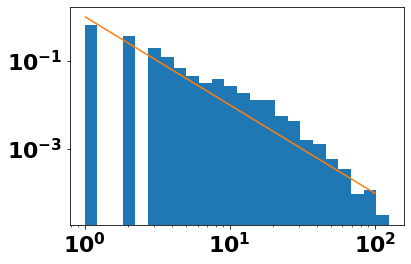

In [38]:
deg = [G_cln.degree[node] for node in G_cln.nodes]
deg.sort()
plt.hist(deg, log = True, density = True, bins =np.logspace(0,2.1,25))
x = np.linspace(0,100,100)
plt.plot(x, x**-2)
plt.xscale('log')

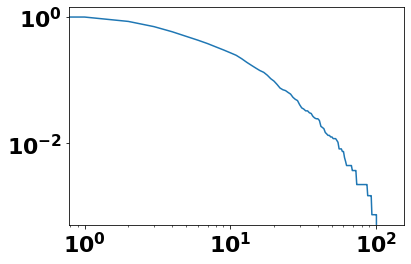

In [39]:
deg = np.array(deg)
nums = [np.count_nonzero(deg == i) for i in range(deg[-1]+1)]
num = [sum(nums[:i]) for i in range(len(nums))]
num = [(num[-1] - num[i])/num[-1] for i in range(len(num))]
plt.plot(num)
y = []
for i in range(len(x)):
    y.append(1 - sum(x[:i+1]))
plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')

In [40]:
G_weighted = nx.Graph()
#G_weighted.add_edges_from(G.edges, weight)

for edge in G_cln.edges:
    if isinstance(edge[0],int)==False:
        if isinstance(edge[1], int)==False:
            G_weighted.add_edge(edge[0],edge[1], weight = 1)
            continue
    if isinstance(edge[0], int) == True:
        list1 = clusters[edge[0]]
    else:
        list1 = [edge[0]]
    if isinstance(edge[1], int) == True:
        list2 = clusters[edge[1]]
    else:
        list2 = [edge[1]]
    w = 0
    for l1 in list1:
        nb = list(nx.neighbors(G, l1))
        nb.sort()
        common = [v for v in nb if v in list2]
        w += len(common)
    G_weighted.add_edge(edge[0], edge[1], weight = w)

Text(0.5, 1.0, 'Degree Density of Condensed Graph')

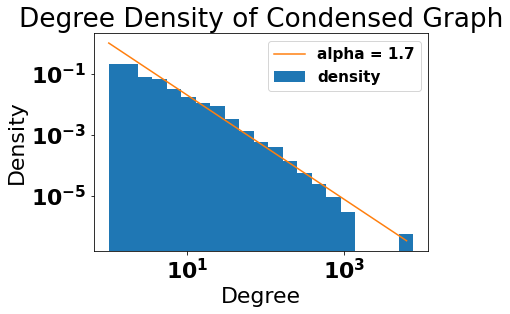

In [41]:
degw = [G_weighted.degree(node, weight='weight') for node in G_weighted.nodes]
bins = 2**(np.linspace(0,14, 20))
n = 20
m = np.log2(5000)
loglist = [2**(i*m/n) for i in range(n+2)]
loglist.remove(loglist[1])

degw.sort()
plt.figure()
#plt.subplot(121)
#plt.hist([G.degree()[node] for node in G.nodes], log = True, density = True, bins = loglist)
#plt.xscale('log')
#plt.subplot(122)
plt.hist(degw, log = True, density = True, bins = loglist)
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Density')
plt.plot(np.logspace(0, 3.8, 25), np.logspace(0,3.8,25)**-1.7)
plt.legend(['alpha = 1.7', 'density'], fontsize = 'x-small')
plt.title('Degree Density of Condensed Graph')

In [42]:
for node in G_weighted.nodes:
    if G_weighted.degree(node, weight = 'weight') > 2000:
        print(node, G_weighted.degree(node, weight='weight'), clustersize[node])

16 5485 202
23 5483 162


8
[True, True, True, True, True, True, True, True]
235 243


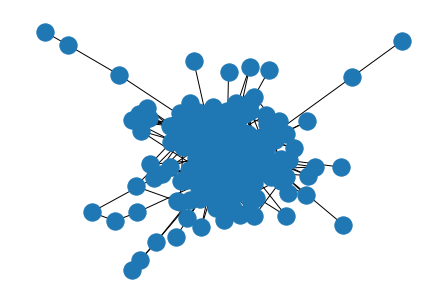

In [43]:
subset = []
iscluster = {}
for n in G_cln.nodes:
    if isinstance(n, int):
        subset.append(n)
        iscluster[n] = True
    else:
        iscluster[n] = False
G_clusters = G_weighted.subgraph(subset)
color_map = {False: 'blue', True: 'red'}
size_map = {False: 1, True: 20}
print(nx.number_connected_components(G_clusters))
largest_cc = max(nx.connected_components(G_clusters), key=len)
nx.draw(G_clusters.subgraph(largest_cc))
print([i in largest_cc for i in goodclusters])
print(len(largest_cc), G_clusters.number_of_nodes())

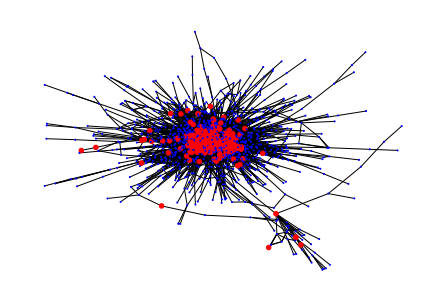

In [44]:
nx.draw(G_weighted, node_color=[color_map[iscluster[node]] for node in G_weighted.nodes], node_size = [size_map[iscluster[node]] for node in G_weighted.nodes])

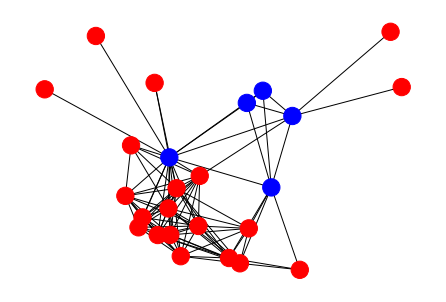

In [45]:
is_in_19 = {}
cluster13_nbs = clusters[19].copy()
for v in clusters[19]:
    cluster13_nbs = list(set(cluster13_nbs + (list(nx.neighbors(G, v)))))
for c in cluster13_nbs:
    if c in clusters[19]:
        is_in_19[c] = True
    else:
        is_in_19[c] = False
cluster13_color = {True: 'blue', False: 'red'}
nx.draw(G.subgraph(cluster13_nbs), node_color = [cluster13_color[is_in_19[node]] for node in cluster13_nbs])

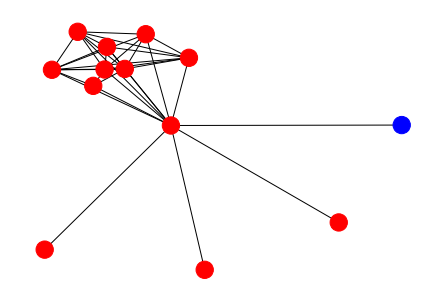

In [46]:
nx.draw(G_weighted.subgraph(list(nx.neighbors(G_weighted, 19)) + [19]), node_color = [cluster13_color[node == 16] for node in list(nx.neighbors(G_weighted, 19)) + [19]])

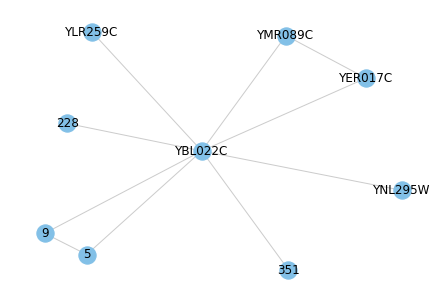

In [48]:
nx.draw(G_weighted.subgraph(sp_tree(G_weighted, 'YBL022C', k=1).nodes), with_labels = True, node_color = '#82c0e7', edge_color = '#cccccc')


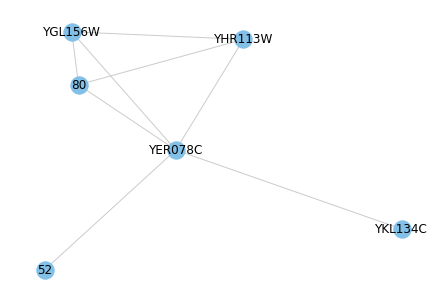

In [49]:
nx.draw(G_weighted.subgraph(sp_tree(G_weighted, 'YER078C', k=1).nodes), with_labels = True, node_color = '#82c0e7', edge_color = '#cccccc')

In [51]:
L = get_L(G_weighted)
eig, v = np.linalg.eigh(L.todense())
eig.sort()
#plt.plot(eig[-10:])

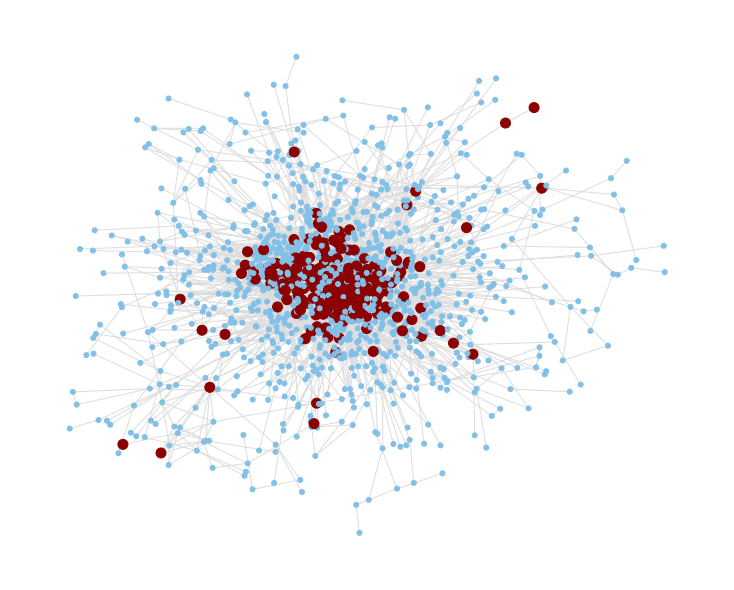

In [134]:
#Diagrams for presentation
pimnodes = sp_tree(G, 'YBL022C', 3)
pimnbs = []
for n in pimnodes.nodes:
    if n in G_weighted.nodes:
        pimnbs.append(n)
    else:
        pimnbs.append(node_cl[n])
pimnbs = list(set(pimnbs))
color = []
size = []
for node in G_weighted.nodes:
    if node == 'YBL022C':
        #color.append('black')
        color.append('#82c0e7')
        size.append(200)
    elif isinstance(node, int):
        color.append('darkred')
        size.append(100)
    else:
        color.append('#82c0e7')
        size.append(25)
plt.figure(1, figsize=(10,8))
#nx.draw(G_weighted.subgraph(pimnbs), node_color = color, node_size = size, with_labels=False, edge_color = '#dddddd', pos = nx.spring_layout(G_weighted.subgraph(pimnbs), iterations = 50, k = 0.1))
nx.draw(G_weighted, node_color = color, node_size = size, with_labels=False, edge_color = '#dddddd', pos = nx.spring_layout(G_weighted, iterations = 50, k = 0.1))
plt.show()

In [54]:
print(nx.diameter(G_weighted), nx.diameter(G))

14 17


In [55]:
goodclusters = [59,32, 321,3,37,237,178,201]
def get_paths(subset, G):
    all_paths = []
    for i in range(len(subset)):
        for j in range(i + 1, len(subset)):
            pairspaths = [p for p in nx.all_shortest_paths(G_weighted, subset[i], subset[j])]
            all_paths.append(pairspaths)
    return all_paths

In [56]:
cluster_centrality =pathway_centrality(goodclusters, G_weighted)
cluster_centrality = dict_to_sortedlist(cluster_centrality)
cluster_centrality.reverse()
#print(clustersize[195])
#print(cluster_centrality)

In [88]:
G_cc = G_clusters.subgraph(largest_cc)
eig_centrality = nx.eigenvector_centrality(G_cc)
eig_centrality = list(eig_centrality.items())
eig_rank = dict()
for i in range(len(eig_centrality)-1):
    for j in range(i+1, len(eig_centrality)):
        if eig_centrality[i][1] > eig_centrality[j][1]:
            temp = eig_centrality[i]
            eig_centrality[i] = eig_centrality[j]
            eig_centrality[j] = temp
eig_centrality.reverse()
for i in range(len(eig_centrality)):
    eig_rank[eig_centrality[i][0]] = i+1
    if eig_centrality[i][0] in goodclusters:
        print(i+1, eig_centrality[i])
eig_centrality = dict(eig_centrality)

30 (37, 0.10411359742577639)
48 (178, 0.0731801820554068)
58 (32, 0.0640493437438199)
60 (3, 0.06265934814055704)
65 (201, 0.05845062793120544)
106 (59, 0.03542089785892998)
143 (237, 0.021910788014707958)
175 (321, 0.014289968949534661)


In [89]:
betweenness_centrality = nx.betweenness_centrality(G_cc)
betweenness_centrality = dict_to_sortedlist(betweenness_centrality)
betweenness_centrality.reverse()
bw_rank = dict()
clust = 0
for i in range(len(betweenness_centrality)):
    bw_rank[betweenness_centrality[i][0]] = i+1
    if isinstance(betweenness_centrality[i][0], int):
        clust += 1
    if betweenness_centrality[i][0] in goodclusters:
        print(i+1, betweenness_centrality[i])
    if betweenness_centrality[i][0] in ['YBL022C', 'YER078C']:
        print(i+1, betweenness_centrality[i], clust)

5 (32, 0.05303529714906727)
12 (37, 0.03386550685241555)
32 (178, 0.014836306094280376)
41 (201, 0.012338579387907818)
51 (3, 0.010178523555949408)
55 (59, 0.00991672970946751)
191 (237, 0.00033168655381999825)
201 (321, 0.00017276810249805208)


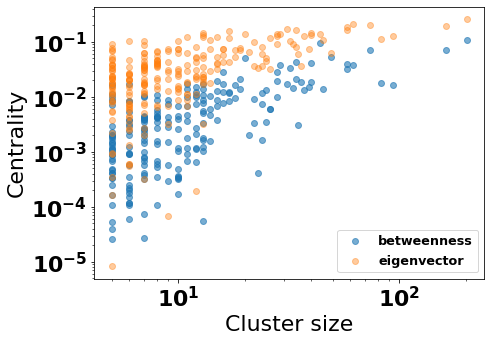

In [131]:
betweenness_centrality = dict(betweenness_centrality)
plt.figure(figsize = (7,5))
plt.scatter([clustersize[node] for node in largest_cc],[betweenness_centrality[node] for node in largest_cc], alpha = 0.6)
plt.scatter([clustersize[node] for node in largest_cc],[eig_centrality[node] for node in largest_cc], alpha = 0.4)
plt.xlabel('Cluster size')
plt.ylabel('Centrality')
plt.xscale('log')
plt.yscale('log')
plt.legend(['betweenness', 'eigenvector'], fontsize = 'xx-small')

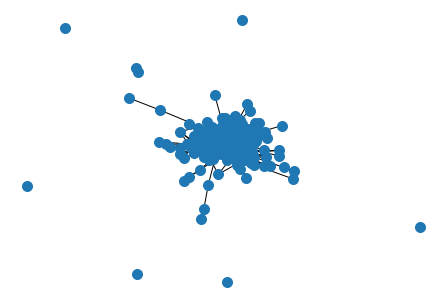

In [59]:
nx.draw(G_clusters, node_size = 100, pos = nx.spring_layout(G_clusters, iterations = 20))

In [60]:
plt.figure(2, figsize = (10,8))
#nx.draw(G_weighted, node_color = '#82c0e7', node_size = 25, with_labels=False, edge_color = '#dddddd', pos = nx.spring_layout(G_weighted, iterations = 50, k = 0.1))
plt.show()

<Figure size 720x576 with 0 Axes>

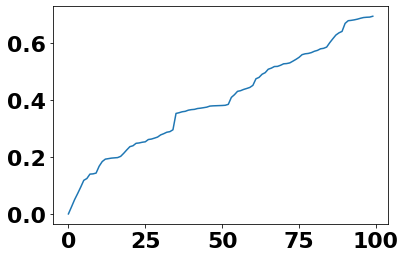

In [139]:
Graph = G_weighted #.subgraph(clusters[16])
L = get_L(Graph)
eig, v = np.linalg.eigh(L.todense())
eig.sort()
plt.plot(eig[:100])

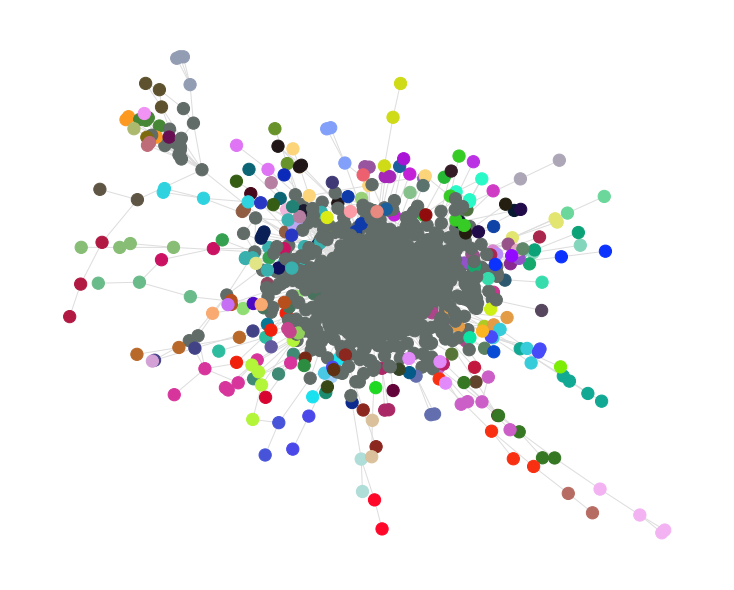

In [137]:
col_16 = cluster(get_L(Graph), 150, Graph)
colours = {}
for i in range(307):
    colours[i] = [random.random(), random.random(), random.random()]
plt.figure(2, figsize=(10,8))
nx.draw(Graph, node_size = 150, node_color = [colours[col_16[node]] for node in Graph.nodes], edge_color='#dddddd')#, pos = nx.spring_layout(G_16, iterations = 20, k = 0.2), edge_color = '#bbbbbb')

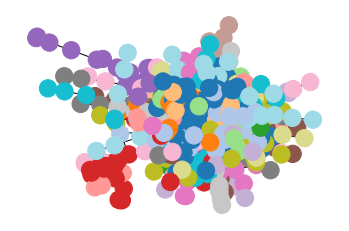

In [63]:
inflation = 2
matrix = nx.to_scipy_sparse_matrix(Graph, weight='weight')
result = mcl.run_mcl(matrix, inflation=inflation)
mcl_clusters = mcl.get_clusters(result)
mcl.draw_graph(matrix, mcl_clusters, with_labels = False)

In [64]:
#print((mcl_clusters))
plt.figure(figsize=(10,8))
nodes = list(Graph.nodes())
systematic_clusters = [[nodes[index] for index in cluster] for cluster in mcl_clusters]
col_dict = {}
nogos = 0
for i in range(len(systematic_clusters)):
    for j in systematic_clusters[i]:
        col_dict[j] = i
        if j == 'YBL022C':
            print(i)
    if nx.is_connected(Graph.subgraph(systematic_clusters[i])) == True and len(systematic_clusters[i]) > 6:
        nogos += 1
plt.figure(4, figsize=(12,12))
#nx.draw(Graph, node_size = 50, node_color = [colours[col_dict[n]] for n in Graph], pos= nx.spring_layout(Graph, iterations=50, k=0.05))
print(len(mcl_clusters))
#mcl.draw_graph(matrix, mcl_clusters, with_labels= False)#, pos = nx.spring_layout(matrix, iterations=20, k =0.1))

0
152


<Figure size 720x576 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [65]:
cc = nx.clustering(G_weighted)
cc = list(cc.values())
#0.5097388344749814
meancc = sum(cc)/len(cc)
print(meancc)

0.30792391661721796
